In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days


In [3]:
# %pdb

In [4]:
debug = True # global var to control debugging

In [5]:
import theano

import theano.tensor as TT

from theano.tensor.shared_randomstreams import RandomStreams

In [6]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float32)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float32)

In [7]:
def default(var, val):
    if var is None:
        return val
    else:
        return var

# LSTM implementation in Theano

Theano fully supports recurrent neural networks. One typically needs only to provide an implementation of a single step of the recurrency.

Please read about the scan function which is used to implement the loops: http://deeplearning.net/software/theano/library/scan.html.

**Attention**: through the code we will assume that the 0-th axis refers to time and that the 1-st axis refers to individual examples inside a minibatch. (This way in a C-major memory layout individual time steps occupy contiguous regions in memory)

In [8]:
def softmax(x):
    """
    Taken from https://github.com/vitruvianscience/OpenDeep/blob/master/opendeep/utils/activation.py
    
    See the Theano documentation.
    Returns the row-wise softmax function of x.
    In the case of 3D input, it returns the scan of softmax applied over the second two dimensions
    (loops over first dimension).
    Parameters
    ----------
    x : 2D or 3D tensor
        Symbolic 2D or 3D Tensor (or compatible).
    Returns
    -------
    2D or 3D tensor
        Row-wise softmax: softmax_{ij}(x) = exp(x_{ij})/sum_k(exp(x_{ik})) applied to `x`. Returns same shape as input.
    """
    if x.ndim == 3:
        cost, _ = theano.scan(fn=TT.nnet.softmax, sequences=x)
        return cost
    return TT.nnet.softmax(x)

In [9]:
class Layer(object):
    def __init__(self, rng=None):
        if rng is None:
            rng = numpy.random
        self.rng = rng
        self._parameters = []
    
    @property
    def parameters(self):
        return self._parameters
    
    def add_param(self, name, shape, initializer, dtype='float32'):
        param = theano.shared(numpy.zeros(
            shape, dtype=dtype), name=name)
        param.tag.initializer = initializer
        self._parameters.append(param)
        setattr(self, name, param)
        
    def initialize(self):
        for p in self.parameters:
            p.set_value(p.tag.initializer.generate(self.rng, 
                                                   p.get_value().shape))


class RecurrentLayer(Layer):
    def __init__(self, **kwargs):
        super(RecurrentLayer, self).__init__(**kwargs)
        self.initial_states = []
    
    def apply(self, X, **kwargs):
        batch_size = X.shape[1]
        outputs_info = []
        for h in self.initial_states:
            h0 = TT.repeat(h, batch_size, axis=0)
            outputs_info.append(dict(initial=h0))
        
        #
        # Scan in theano takes a function which performs a single step of the
        # recurrent computation. Subclasses just need to provide the
        # self.transition function.
        #
        scan_result, scan_updates = theano.scan(
            self.transition,
            sequences=X,
            outputs_info=outputs_info,
            **kwargs
            )
        # Note: this in general will not be the case and we will need to
        # make sure that the updates are given to theano.function
        assert not scan_updates
        return scan_result


class MergeInputHiddens(Layer):
    """
    Merge two sequences - inputs and hidden states and produce an output.
    
    """
    def __init__(self, in_dim, hidden_dim, out_dim,
                 weight_init=None, bias_init=None, 
                 **kwargs):
        super(MergeInputHiddens, self).__init__(**kwargs)
        weight_init = default(
            weight_init, IsotropicGaussian(1.0/sqrt(in_dim)))
        bias_init = default(
            weight_init, Constant(0.))
        
        # Input to output
        self.add_param('Wxo', (in_dim, out_dim), 
                       weight_init)
        
        # Hidden to output
        self.add_param('Who', (hidden_dim, out_dim), 
                       weight_init)
        
        # Output bias
        self.add_param('Bo', (out_dim,), 
                       bias_init)
        
    def apply(self, X, H):
        # Get the shape
        nsteps, bs, nin = X.shape
        nhid = H.shape[2]
        
        # Note - we flatten the steps and batch size
        # as the computation of outputs can be performed in 
        # parallel for all time steps.
        
        O = (X.reshape((nsteps*bs, nin)).dot(self.Wxo) + 
             H.reshape((nsteps*bs, nhid)).dot(self.Who) +
             self.Bo)
        return O.reshape((nsteps, bs, O.shape[1]))
    
class Chain(Layer):
    def __init__(self, **kwargs):
        super(Chain, self).__init__(**kwargs)
        self.children = []
        
    @property
    def parameters(self):
        ret = list(self._parameters)
        for c in self.children:
            ret.extend(c.parameters)
        return ret

In [10]:
class Trainer(object):
    """
    This class computes the updates to parameters using the RMSProp learning rule and adding weight decay.
    
    """
    def __init__(self, net_loss, parameters, inputs):
        self.RMSProp_dec_rate = \
            theano.shared(np.array(0.9, dtype='float32'))
        self.RMSProp_epsilon = \
            theano.shared(np.array(1e-5, dtype='float32'))
        self.lrate = \
            theano.shared(np.array(1e-2, dtype='float32'))
        self.max_grad_norm = \
            theano.shared(np.array(1., dtype='float32'))
        self.wdec = \
            theano.shared(np.array(0., dtype='float32'))

        theano.config.compute_test_value='off' # Turn off for gradient computation
        
        wdec_loss = 0
        for p in parameters:
            if p.name[0]=='W':
                wdec_loss = wdec_loss + (p**2).sum()*self.wdec
        
        grads = theano.grad(net_loss + wdec_loss, parameters)
        updates = []

        grad_norm = 0.

        for g in grads:
            grad_norm = grad_norm + (g**2).sum()
        

        for g,p in zip(grads, parameters):
            step = g
            step = g / TT.maximum(1.0, grad_norm/self.max_grad_norm)
            if 1:
                g2 = theano.shared(p.get_value() * 0.,
                                   name=p.name + '_g2')
                g2_new = (self.RMSProp_dec_rate * g2 + 
                          (1.0 - self.RMSProp_dec_rate) * g**2)
                updates.append((g2, g2_new))
                step = step / TT.sqrt(g2_new + self.RMSProp_epsilon)

            step = self.lrate * step
            updates.append((p, p - step))

        self.train_function = theano.function(inputs, 
                                              [net_loss, net_loss + wdec_loss, grad_norm], 
                                              updates=updates)

In [11]:
class LSTM_RNN(RecurrentLayer):
    """
    Implementation follows Alex Graves, Abdel-rahman Mohamed and Geoffrey Hinton
    "SPEECH RECOGNITION WITH DEEP RECURRENT NEURAL NETWORKS"
    http://www.cs.toronto.edu/~fritz/absps/RNN13.pdf
    """
    def __init__(self, in_dim, hidden_dim,
                 hidden_activation=TT.tanh,
                 rec_weight_init=None,
                 weight_init=None, bias_init=None, 
                 forget_bias_init=None, 
                 **kwargs):
        super(LSTM_RNN, self).__init__(**kwargs)
        rec_weight_init = default(
            rec_weight_init, IsotropicGaussian(1.0/sqrt(hidden_dim)))
        weight_init = default(
            weight_init, IsotropicGaussian(1.0/sqrt(in_dim)))
        bias_init = default(
            weight_init, Constant(0.))
        forget_bias_init = default(
            weight_init, Constant(1.))
        self.hidden_activation = hidden_activation
        
        #
        # Gates
        #
        
        for gate in 'ifo':
            self.add_param('Wx' + gate, (in_dim, hidden_dim), 
                           weight_init)
            self.add_param('Wh' + gate, (hidden_dim, hidden_dim), 
                           weight_init)
            # Note: a cell is only connected to its own gates
            # Wc... are diagonal - so we allocate only a vector
            # for them
            self.add_param('Wc' + gate, (hidden_dim,), 
                           weight_init)
            self.add_param('B' + gate, (hidden_dim,), 
                           bias_init)
        
        #
        # Note - forget gate bias has a different initializer, because
        # we often want to initialize it to 1
        #
        self.Bf.tag.initializer = forget_bias_init
        
        # Cell
        self.add_param('Wxc', (in_dim, hidden_dim), 
                       weight_init)
        self.add_param('Whc', (hidden_dim, hidden_dim), 
                       weight_init)
        self.add_param('Bc', (hidden_dim,), 
                       bias_init)
        
        # Initial states
        self.add_param('h0', (1, hidden_dim), 
                       bias_init)
        self.initial_states.append(self.h0)
        self.add_param('c0', (1, hidden_dim), 
                       bias_init)
        self.initial_states.append(self.c0)
        
        
    def transition(self, x, h, c):
        """
        One step of LSTM transition.
        
        x is the previous input
        h is the previous hidden state
        c is the previous memory cell content
        """
        
        #
        # Please note:
        # The implementation below is not speed-optimal
        # usually, it pays off to group similar matrix multiplications
        # by grouping gates.
        #
        # Also, input-related computations should be moved out of scan since
        # they can be done for all steps in parallel.
        #
        
        
        s = TT.nnet.sigmoid

        # Note: for cells we do element0wise multiplication which 
        # is equvalent to a matrix multiplication with a diagonal matrix!
        i = s(x.dot(self.Wxi) + h.dot(self.Whi) + c*self.Wci + self.Bi)
        f = s(x.dot(self.Wxf) + h.dot(self.Whf) + c*self.Wcf + self.Bf)
        
        c_new = f*c + i*self.hidden_activation(x.dot(self.Wxc) + h.dot(self.Whc) + self.Bc)
        o = s(x.dot(self.Wxo) + h.dot(self.Who) + c_new*self.Wco + self.Bo)
        h_new = o * self.hidden_activation(c_new)
        
        return h_new, c_new

In [12]:
# we encode be input and output as a 1-of-N vector, thus every element of the input and output is a 1x10 vector with one '1'.

def class_encoding(n, num_classes = 10):
    ret = zeros(shape=(num_classes))
    ret[n] = 1
    return ret

def class_decoding(v):
    return argmax(v)

# This should be rewritten without the use of loops

def decode_matrix(matrix):
    decoded_matrix = zeros(shape = (matrix.shape[0], matrix.shape[1]))
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            decoded_matrix[i][j] = class_decoding(matrix[i][j])
    return decoded_matrix

def encode_matrix(matrix, num_classes = 10):
    encoded_matrix = zeros(shape = (matrix.shape[0], matrix.shape[1], num_classes))
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            encoded_matrix[i][j] = class_encoding(matrix[i][j])
    return encoded_matrix.astype("float32")


def gen_copy_example(T, seq_len, batchsize):
    rng = numpy.random
    
    sequence = rng.randint(2, 10, size=(seq_len, batchsize))
    
    X = np.concatenate((sequence,
                         np.zeros(shape=(T - 1, batchsize)),
                         np.ones(shape=(1, batchsize)), 
                         np.zeros(shape=(seq_len, batchsize))))
    
    Y = np.concatenate((np.zeros(shape=(T + seq_len, batchsize)),
                        sequence.reshape(seq_len, batchsize)))
    
    
    return encode_matrix(X), encode_matrix(Y)


Xc, Yc = gen_copy_example(4, 4, 2)
#print Xc.shape, Yc.shape
#print 'X:', Xc[:,0,:], '\nY:', Yc[:,0,:]

At each point in time, network receives an input of size 1x10 (1-hot encoding), propagets the signal through a layer of
hidden_dim LSTM neurons and produces an output of size 1x10 (also treated as 1-hot encoding). Softmax is applied at
the end to get calculated probabilities. Cross-entropy is used as a loss function.  

In [13]:
class CopyNet(Chain):
    def __init__(self, hidden_dim, num_layers=1,
                 **kwargs):
        super(CopyNet, self).__init__(**kwargs)
        self.recs = []
        
        for hid in xrange(num_layers):
            if hid == 0:
                in_dim = 10
            else:
                in_dim = hidden_dim
                
            rec = LSTM_RNN(in_dim=in_dim, hidden_dim=hidden_dim)
            
            self.recs.append(rec)
            self.children.append(rec)
        
        self.merge = MergeInputHiddens(
            in_dim=10, hidden_dim=hidden_dim,
            out_dim=10
            )
        self.children.append(self.merge)
        
        self.X = TT.tensor3('X')
        self.Y = TT.tensor3('Y')
        
        self.inputs = [self.X, self.Y]
    
    def apply(self, X):
        H = X
        for rec in self.recs:
            H = rec.apply(H)
            H = H[0] # we don't use cell contents
        O = self.merge.apply(X, H)
        
        return softmax(O)
    
    # We use cross-entropy to measure the efficiency of the network. You can also a
    def get_loss(self):
        copy_net_output = self.apply(self.X)
        # return ((copy_net_output - self.Y)**2).mean() # MSE
        return -(self.Y * TT.log(copy_net_output)).mean() # cross entropy
    
    def get_output(self):
        copy_net_output = self.apply(self.X)
        return copy_net_output



In [14]:
Xc, Yc = gen_copy_example(4, 10, 1)
print Xc.shape, Yc.shape
theano.config.compute_test_value='off'
theano.config.print_test_value=True
debug = False

# Set the nubmer of hidden cells here. Note that intuitively you need more cells if you want to copy longer sequences. 
# The ratio 4 neurons per max seqence lenght seems to be fine.
copy_net = CopyNet(hidden_dim=20)
copy_net.initialize()
copy_net_loss = copy_net.get_loss()
copy_net_output = copy_net.get_output()

copy_test_function = theano.function(copy_net.inputs, 
                                       copy_net_loss)
copy_check_output = theano.function([copy_net.X], 
                                       copy_net_output)

copy_test_function(Xc, Yc)

(24, 1, 10) (24, 1, 10)


/pio/os/anaconda/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


array(0.25090810656547546, dtype=float32)

In [15]:
copy_trainer = Trainer(copy_net_loss, copy_net.parameters, copy_net.inputs)

The problem we are solving is described in the following paper, section 5.1: http://arxiv.org/pdf/1511.06464v2.pdf.
The input is a seqeunce of size 2 * n + T and each element of the input is of one of the 10 classes, which will name by the numbers from 0 to 9. First n elements is an arbitrary sequence of numbers 2...9. Then, T - 1 '0's follow. The next element is a single '1' and the last n elements are '0's. The desired output is a sequence of the same length, where the first T + n elemtnts are '0's followed by sequence from the beginnig of the input. The kth element of the output should be produced after the net sees the kth element of the input.

The difficulty of the task is the fact that a network has to put elements in the memory, store them for a long time and then reproduce them. 

In the cited paper authors used n = 10 (length of the sequence to reproduce) and 40 neurons. Their network was only a little bit better than baseline (a program that outputs T + n '0's and n random numbers) when T = 100 and did not learn at all for larger T.

It tunrs out that this task is in fact easy with the use of curriculum. My network was able to learn to perfectly reproduce the sequence with the time lag of 400.

The curriculum is used both for the n (seq_len) as well as T (lag). In every consecutive batch the lag is of random size. As the newtork get better, we increase both the maximium allowed lag, as well as the sequnece lenght. After the training, the net should be able to copy a sequence of any length over any time lag not greater than the learnt ones. 

0 [array(0.26855704188346863, dtype=float32), array(0.26883089542388916, dtype=float32), array(0.019072508439421654, dtype=float32)]
0.258574187756
[[ 5.]
 [ 2.]]
2000 [array(0.003358281683176756, dtype=float32), array(0.003752228105440736, dtype=float32), array(2.151214903278742e-05, dtype=float32)]
0.00338579667732
[[ 3.]
 [ 3.]]
2043 Increasing lag to:  5 seq_len is  1
2060 Increasing lag to:  6 seq_len is  1
2236 Increasing lag to:  7 seq_len is  1
2331 Increasing lag to:  8 seq_len is  1
2451 Increasing lag to:  9 seq_len is  1
2517 Increasing lag to:  10 seq_len is  2
4000 [array(0.0008926283335313201, dtype=float32), array(0.0013324925675988197, dtype=float32), array(4.871470446232706e-05, dtype=float32)]
0.0140950428322
[[ 5.  4.]
 [ 5.  5.]]
6000 [array(0.0008799178758636117, dtype=float32), array(0.0013573311734944582, dtype=float32), array(1.2832471838919446e-05, dtype=float32)]
0.0123029416427
[[ 9.  4.]
 [ 9.  9.]]
8000 [array(0.010725733824074268, dtype=float32), array(0.

/pio/os/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/pio/os/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


 Increasing lag to:  500 seq_len is  5


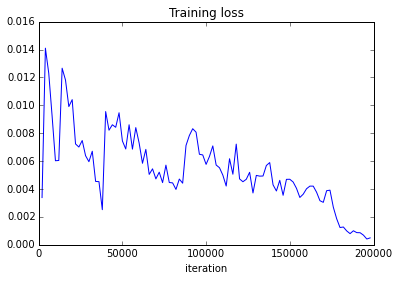

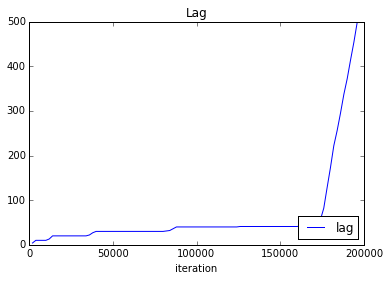

In [16]:
copy_net.initialize()

# Feel free to tune the learing rate, this one worked the best for me. 
# We don't use any learing scheuling (lrate is constant), as every time the net starts getting closer to optimum, 
# we just make the problem harder (increasse the time lag) instead of trying to find the optimum more accurately
# I tried using learing rate scheduling, without any noticable iprovement

lrate = 5e-3
copy_trainer.lrate.set_value(lrate)

# Set weight decay, it seems to be helpful
copy_trainer.wdec.set_value(1e-6)

losses = []

# Set the sequence parameters. We start from a trivial task and make it more difficult as we make progress.

lag0 = 4
lag = lag0
seq_len0 = 1
seq_len = seq_len0
max_seq_len = 5 # Note that you may need more neurons for a longer sequence
max_lag = 500
max_it = 200000

for i in xrange(max_it):
    # lrate = 
    # copy_trainer.lrate.set_value(lrate)
    
    # We don't want the network to forget a solution for shorter sequences, so the sampled example is of a random size.
    # This seems to be important for generalization.
    this_lag = randint(lag0, lag + 1)
    this_len = randint(seq_len0, seq_len + 1)
    
    # You can set the batch size here (or leave 32, which seems reasonable)
    Xc, Yc = gen_copy_example(this_lag, this_len, 32)
    ret = copy_trainer.train_function(Xc, Yc)
    
    # If the results are good enough, increase the length. 
    if this_lag > 0.9 * lag and this_len == seq_len and ret[0] < 3e-3:
        lag += 1
        seq_len = min(max_seq_len, lag / 10 + 1)
        if lag > max_lag:
            max_it = i + 10000
            lag = max_lag
        print i, "Increasing lag to: ", lag , "seq_len is ", seq_len
    if i%2000 == 0:
        print i, ret
        Xc, Yc = gen_copy_example(lag, seq_len, 32)
        ret = copy_test_function(Xc, Yc)
        print ret
        if i != 0: #ignore noisy start
            losses.append((i,) + tuple([ret, lag]))
        decoded_input = decode_matrix(Xc)
        decoded_output = decode_matrix(copy_check_output(Xc).reshape(Xc.shape))
        
        # Sanity check
        # Note that here we check the net's beahaviour on the max test, whereas most of training examples are shorter.
        # We trust that the net outputs T + n '0's at the start, so we don't print it here for the transparency
        print vstack([decoded_input[:,0].ravel()[:seq_len], decoded_output[:,0].ravel()[-seq_len:]])

        
# print charts

losses_a = np.array(losses)

p1 = plt.figure(1)

legend(loc='lower right')
title('Training loss')
xlabel('iteration')

plot(losses_a[:,0], losses_a[:,1], label='rms')

savefig('losses_small.png')
p1.show()

#semilogy(losses_a[:,0], losses_a[:,2], label='rms + wdec')
#semilogy(losses_a[:,0], losses_a[:,2], label='rms')
#plot(losses_a[:,0], losses_a[:,3], label='grad norm')

p2 = plt.figure(2)

plot(losses_a[:,0], losses_a[:,2], label='lag')

legend(loc='lower right')
title('Lag')
xlabel('iteration')

savefig('lag_small.png')
p2.show()

Note the very rapid decrease in the loss as the lag gets bigger. This is mostly caused by the fact that the loss is the average loss over the whole genereted sequence, so the loss is sum_of_losses/length. The length increases, but sum_of_losses stays more or less the same, as the network is still rather confident that it should output '0's before seeing a '1' on the input.

Now let's wee what the trained network can do.

0.00298358732834 0.12 0.00545454545455
[[ 8.  3.  2.  7.  3.]
 [ 8.  3.  2.  3.  3.]]
0.000221762951696 0.14 0.00538461538462
[[ 7.  9.  7.  7.  5.]
 [ 7.  9.  7.  7.  5.]]
0.000296104495646 0.09 0.003
[[ 5.  2.  4.  4.  9.]
 [ 5.  2.  4.  4.  9.]]
0.000297918100841 0.14 0.00411764705882
[[ 4.  2.  3.  5.  4.]
 [ 4.  2.  3.  5.  4.]]
9.90223124973e-05 0.15 0.00394736842105
[[ 9.  6.  6.  8.  5.]
 [ 9.  6.  6.  8.  5.]]
0.00142532098107 0.14 0.00333333333333
[[ 8.  3.  6.  3.  7.]
 [ 8.  3.  6.  8.  8.]]
0.000566864386201 0.12 0.00260869565217
[[ 4.  8.  8.  8.  4.]
 [ 4.  8.  8.  8.  8.]]
3.50811023964e-05 0.13 0.0026
[[ 4.  7.  6.  6.  5.]
 [ 4.  7.  6.  6.  5.]]
0.00085704337107 0.18 0.00333333333333
[[ 5.  4.  3.  9.  3.]
 [ 5.  4.  3.  3.  3.]]
0.000754897890147 0.08 0.00137931034483
[[ 8.  6.  8.  3.  4.]
 [ 8.  6.  8.  3.  8.]]
0.000472381711006 0.19 0.00306451612903
[[ 7.  9.  6.  8.  3.]
 [ 7.  9.  6.  8.  8.]]
9.879834397e-05 0.17 0.00257575757576
[[ 4.  4.  8.  8.  8.]
 [ 4. 

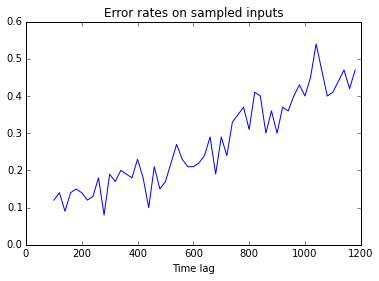

In [21]:
seq_len = 5

err_rates = []

for lag in range(100, 1200, 20):
    err = 0
    err_all = 0
    for i in range(20):
        Xc, Yc = gen_copy_example(lag, seq_len, 1)
        ret = copy_test_function(Xc, Yc)

        decoded_input = decode_matrix(Xc)
        decoded_output = decode_matrix(copy_check_output(Xc).reshape(Xc.shape))

        err += (decoded_input.ravel()[:seq_len] != decoded_output.ravel()[-seq_len:]).mean()
        err_all += (np.hstack([np.zeros(seq_len + lag), decoded_input.ravel()[:seq_len] ]) != decoded_output.ravel()).mean()
    
    err /= 20
    err_all /= 20
    err_rates.append((lag,) + tuple([ret, err, err_all]))

    print ret, err, err_all
    print vstack([decoded_input.ravel()[:seq_len], decoded_output.ravel()[-seq_len:]])
    #print hstack([decoded_input, decoded_output])
    
    
    
errors_a = np.array(err_rates)

p1 = plt.figure(3)

legend(loc='lower right')
title('Error rates on sampled inputs')
xlabel('Time lag')

plot(errors_a[:,0], errors_a[:,2], label='err_rate')
#plot(errors_a[:,0], errors_a[:,2], label='err_rate')
#plot(errors_a[:,0], errors_a[:,3], label='err_rate')

savefig('errors_small.png')
p1.show()


Error presented above is the fraction of missed predictions. It gets higher as the time lag increases, but the results are still pretty good. For short seqences (<500) the net about 4/5 digits right. For instances twice as big as the ones that the net has ever sen druring the training, it gets about 3/5 digits correct.